In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
df.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Data Cleaning
# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

# Create Features: Population^2, Murder binary, Robbery, binary
# More specifically, create binary categories for murder and robery
df['Population^2'] = df['Population']**2
df['Murder'] = np.where(df['Murder']>0, '1', '0')
df['Robbery_binary'] = np.where(df['Robbery']>0, '1', '0')
#df['Aggravated_Assault'] = np.where(df['Aggravated_Assault']>0, '1', '0')

#Convert new columns to int
df[['Population^2']] = df[['Population^2']].astype(int)
df[['Murder']] = df[['Murder']].astype(int)
df[['Robbery_binary']] = df[['Robbery_binary']].astype(int)
#df[['Aggravated_Assault']] = df[['Aggravated_Assault']].astype(int)

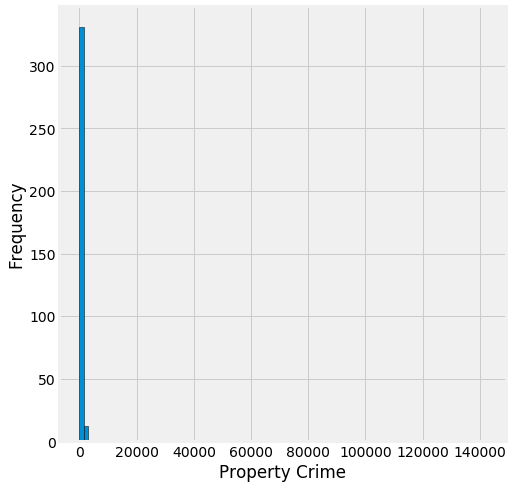

In [6]:
plt.figure(figsize=(8,8))
plt.style.use('fivethirtyeight')
plt.hist(df['Propertycrime'], bins=100, edgecolor='k')
plt.xlabel('Property Crime')
plt.ylabel('Frequency')
plt.show()

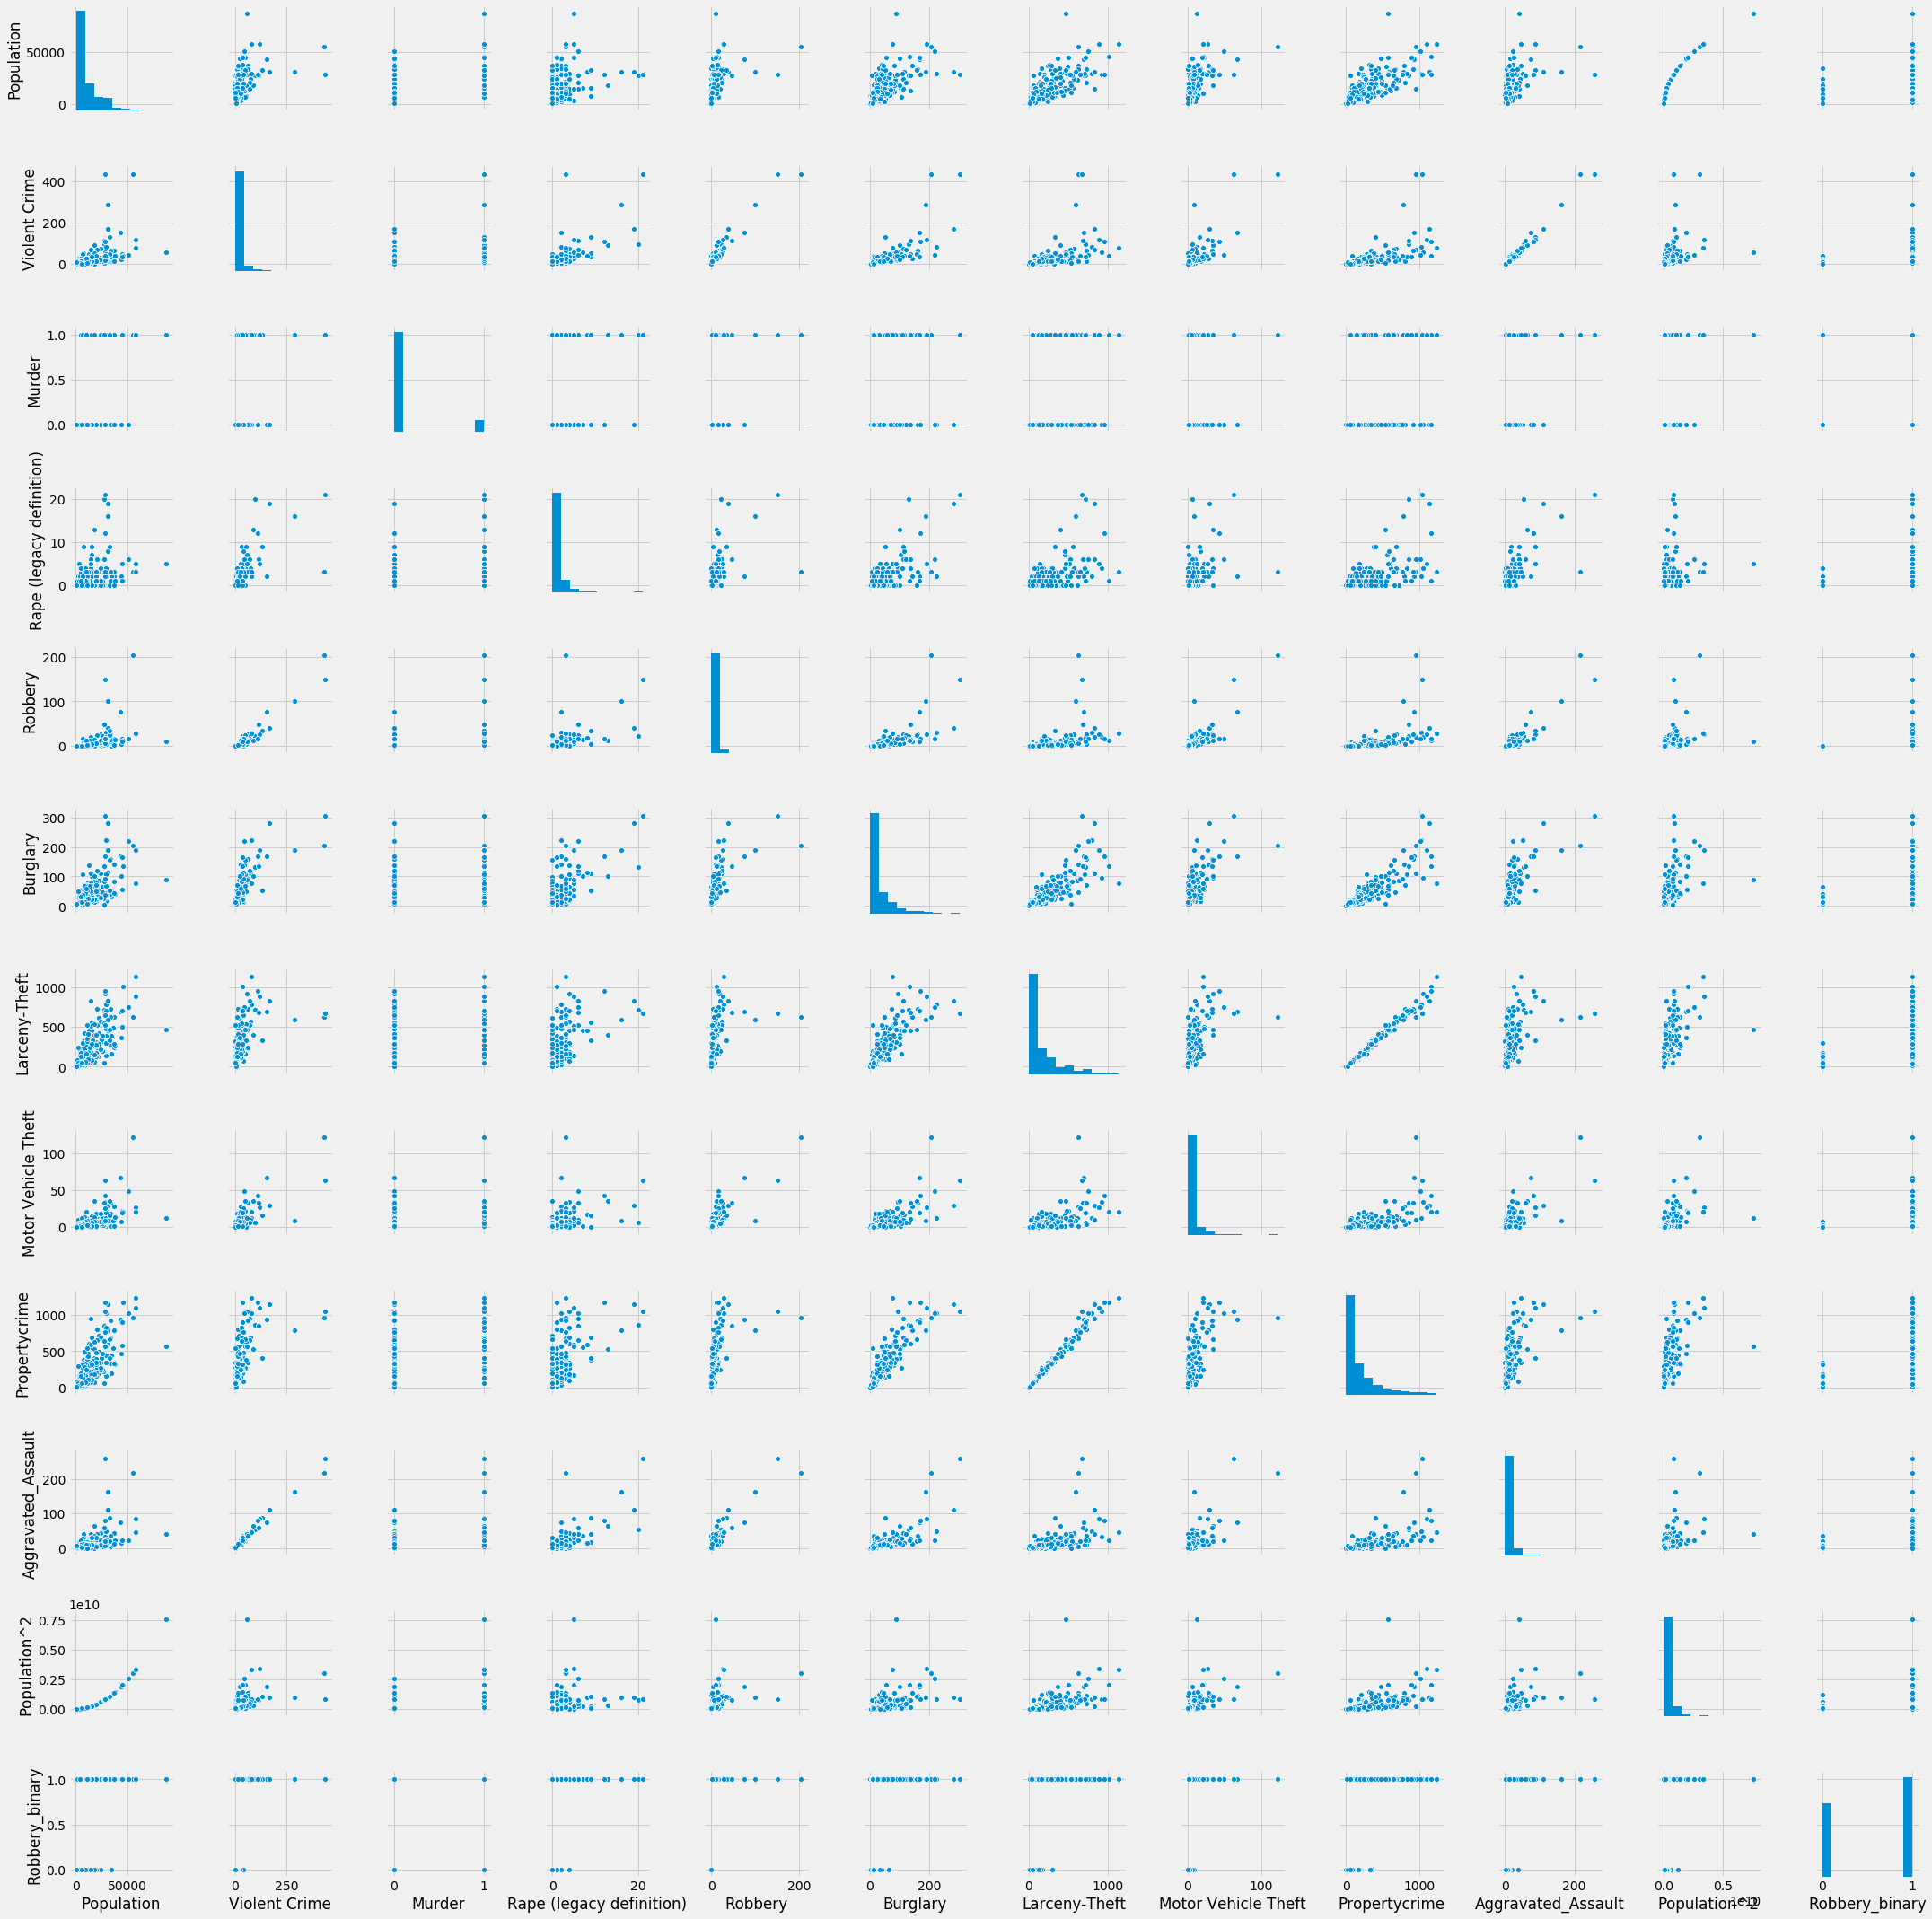

In [7]:
# Remove Outliers by the following rule:
# On the low end, an extreme outlier is below  $\text{First Quartile} -3 * \text{Interquartile Range}$
# On the high end, an extreme outlier is above $\text{Third Quartile} + 3 * \text{Interquartile Range}$

# Calculate first and third quartile
first_quartile = df['Propertycrime'].describe()['25%']
third_quartile = df['Propertycrime'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df['Propertycrime'] > (first_quartile - 3 * iqr)) &
            (df['Propertycrime'] < (third_quartile + 3 * iqr))]

sns.pairplot(df)

In [19]:
df.describe()

,Population,Violent Crime,Murder,Rape (legacy definition),Robbery,Burglary,Larceny-Theft,Motor Vehicle Theft,Propertycrime,Aggravated_Assault,Population^2,Robbery_binary,principalcomponent_1,principalcomponent_2
count,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000,307.000
mean,10879.078,17.586,0.101,1.231,5.134,32.606,166.199,5.130,203.935,11.039,251392979.026,0.580,-5.865,0.571
std,11553.069,43.693,0.302,2.736,16.977,45.128,201.968,10.836,249.318,24.978,612164717.539,0.494,211.578,43.410
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,276676.000,0.000,-175.366,-114.323
25%,2818.000,1.000,0.000,0.000,0.000,6.000,28.000,0.000,35.500,1.000,7941700.000,0.000,-146.509,-6.734
50%,6676.000,5.000,0.000,0.000,1.000,16.000,87.000,2.000,104.000,4.000,44568976.000,1.000,-94.526,1.380
75%,15088.000,17.000,0.000,1.000,4.000,41.500,236.000,5.000,290.000,11.000,227657945.000,1.000,48.953,4.117
max,87204.000,435.000,1.000,21.000,204.000,304.000,1012.000,122.000,1167.000,259.000,7604537616.000,1.000,955.242,440.800


In [20]:
# Removing outliers seem largely inconsequential on the skew of the data as the medians tend to hover around 0 
# for most of the variables. Removing outliers, therefore, does not improve the skew of distributions.
# A more significant change may be to convert all variables to Binary Variables, given the fact that
# there are many 0 values in each variable any way.
# Based on the predictor of whether the certain type of crime occurs, or not, we may be able to gain more insight
# on predicting Murder.

In [10]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 2.07895808e-02 -1.38796201e-07  1.11467925e+02  7.83319708e+01]]

Intercept: 
 [-41.0397189]

R-squared:
 0.6832928164894707


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [11]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train,).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.6630819484016295
Testing on sample:0.6832928164894707


In [12]:
# Cross-validation with mutliple folds
from sklearn.model_selection import cross_val_score

cross_val_score(regr, x, y, cv=5)

array([0.74615357, 0.57890397, 0.63237418, 0.38600084, 0.69893012])

In [13]:
# Test for significance in parameters
linear_formula = 'Propertycrime ~ Population+Population^2+Murder+Robbery_binary'

# Fit the model to our data using formula
lm = smf.ols(formula=linear_formula, data=df).fit()

In [14]:
lm.params

Intercept        -13.542
Population         5.686
Population ^ 2    -5.673
Murder           103.412
Robbery_binary   105.757
dtype: float64

In [15]:
lm.pvalues

Intercept        0.313
Population       0.176
Population ^ 2   0.177
Murder           0.001
Robbery_binary   0.000
dtype: float64

In [16]:
# Create PCA on the follwing variables: Burglary, Violent Crime, Aggravated_Assault, Larceny-Theft, Motor-Vehicle Theft, Robbery

# Standardize Data
features = ['Burglary', 'Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']
x = df.loc[:, features].values

scaler = StandardScaler()

scaler.fit(x)

pd.DataFrame(data=x, columns=features).head()

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create Merged Data Frame
principalDf = pd.DataFrame(data = principalComponents, columns = ['principalcomponent_1', 'principalcomponent_2'])
principalDf['City'] = df['City']
merged_inner = pd.merge(left=df, right=principalDf, left_on='City', right_on='City')
df = merged_inner

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# Run Model
regr = linear_model.LinearRegression()
y = df['Propertycrime'].values.reshape(-1, 1)
x = df[['Population','Population^2', 'Murder', 'Robbery_binary', 'principalcomponent_1', 'principalcomponent_2']]
regr.fit(x,y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x,y))


Coefficients: 
 [[ 2.07761661e-02 -1.46343729e-07  1.10278902e+02  7.92364334e+01
   4.06366621e-02  5.06055664e-02]]

Intercept: 
 [-42.16877968]

R-squared:
 0.6802996932966087


In [18]:
# Cross Validation test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=50)
print('With 30% holdout: ' + str(regr.fit(x_train, y_train,).score(x_test, y_test)))
print('Testing on sample:' + str(regr.fit(x,y).score(x,y)))

With 30% holdout: 0.49218236660568915
Testing on sample:0.6802996932966087
